In [2]:
with open('Korean_movie_reviews_2016_small.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [3]:
len(texts)

29875

In [7]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

c:\Users\USER\anaconda3\envs\python_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<?, ?B/s]
c:\Users\USER\anaconda3\envs\python_env\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--bert-base-multilingual-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
vocab.txt: 100%|██████████| 87

In [9]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [10]:
y_one_hot[0]

array([1., 0.], dtype=float32)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [14]:
len(X_train)

23900

In [15]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [16]:
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 2
)

model.safetensors: 100%|██████████| 672M/672M [00:07<00:00, 84.7MB/s] 
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_kr_multi"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True,
                     save_weights_only=True,
    )

In [19]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=10, batch_size=128, validation_split=0.1,
                   callbacks=[es, mc])

Epoch 1/10
169/169 [==============================] - 894s 5s/step - loss: 0.5116 - accuracy: 0.7369 - val_loss: 0.4234 - val_accuracy: 0.8050
Epoch 2/10
169/169 [==============================] - 877s 5s/step - loss: 0.3660 - accuracy: 0.8377 - val_loss: 0.4244 - val_accuracy: 0.8130
Epoch 3/10
169/169 [==============================] - 878s 5s/step - loss: 0.2996 - accuracy: 0.8745 - val_loss: 0.3677 - val_accuracy: 0.8406
Epoch 4/10
169/169 [==============================] - 875s 5s/step - loss: 0.2477 - accuracy: 0.8990 - val_loss: 0.4383 - val_accuracy: 0.8238
Epoch 5/10
169/169 [==============================] - 877s 5s/step - loss: 0.2101 - accuracy: 0.9170 - val_loss: 0.4189 - val_accuracy: 0.8506
Epoch 6/10
169/169 [==============================] - 882s 5s/step - loss: 0.1724 - accuracy: 0.9335 - val_loss: 0.4577 - val_accuracy: 0.8490
Epoch 6: early stopping


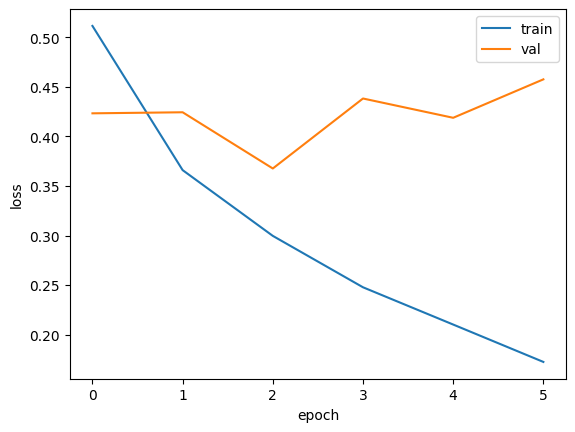

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

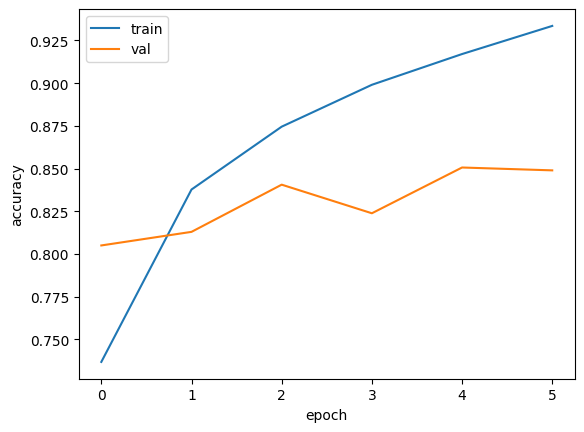

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [24]:
model.load_weights(checkpoint_filepath)
model.evaluate(dict(X_test_tokenized), y_test)

187/187 [==============================] - 71s 379ms/step - loss: 0.3286 - accuracy: 0.8577


[0.3286091983318329, 0.857740581035614]

In [26]:
y_preds = model.predict(dict(X_test_tokenized))

187/187 [==============================] - 73s 377ms/step


In [27]:
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()

In [28]:
import numpy as np

In [29]:
y_predictions = np.argmax(prediction_probs, axis=1)

In [30]:
y_test = np.argmax(y_test, axis=1)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      2643
           1       0.90      0.84      0.87      3332

    accuracy                           0.86      5975
   macro avg       0.86      0.86      0.86      5975
weighted avg       0.86      0.86      0.86      5975

